## Generic Imports, etc.

In [34]:
import numpy as np
import os

np.random.seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

## Importing and preparing MNIST

In [67]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Note that this may take upto a minute.

In [36]:
X, y = mnist["data"], mnist["target"]
mnist.data.shape

(70000, 784)

784 = 28*28, i.e. square images, and a total of 70000 examples, which we will split into training, CV and test data. Let's peek into the examples. The function `plot_digit` reshapes and then plots the training set images.

In [48]:
def plot_digit(data): 
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("on")

5.0

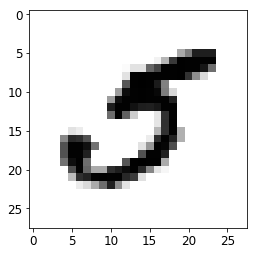

In [166]:
some_digit=X[36000]
plot_digit(some_digit)
y[36000]

We take the first 60k examples as the training set, and the remaining 10k as test set.

In [41]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [42]:
import numpy as np

shuffle_index = np.random.permutation(60000) #shuffling
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training the binary classifier

We try to now identify only one digit, say 5. This classifier is binary, in the sense that it detects whether the digit is a 5 or not.

In [44]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

We set the hyperparameters of total iterations to 5: `max_iter=5`. Also, the tolerance is set to infinity, as defined by the numPy library: `tol=-np.infty`. While MNIST is not a terribly large dataset, we still import the stochastic gradient descent classifier `SGDClassifier` .

In [64]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=-inf, verbose=0, warm_start=False)

In [73]:
print(str(sgd_clf.predict([X[25000]]))+" when y is "+str(y[25000])) #an example of False
print(str(sgd_clf.predict([X[35000]]))+" when y is "+str(y[35000])) #an example of True

[False] when y is 4.0
[ True] when y is 5.0


### Performance of training the classifier

Off-the shelp cross-validation on `scikit-learn`. We split the training set into `cv`=3 folds, and evaluate CV perfomance. This is often not a good idea, and it is preferable to have a separate cross-validation set.

In [97]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9632 , 0.95755, 0.96815])

One should note that using `BaseEstimator` would put a "never-5" classifier at 90% accuracy, so the above numbers are not worth being very excited about! Rather, we import `confusion_matrix` or `precision_score`+`recall_score` or `f1_score`

In [115]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [116]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

print(str(confusion_matrix(y_train_5, y_train_pred)))
print("Precision: " + str(precision_score(y_train_5, y_train_pred)))
print("Recall: " + str(recall_score(y_train_5, y_train_pred)))
print("F1 score: " + str(f1_score(y_train_5, y_train_pred)))

[[52140  2439]
 [  749  4672]]
Precision: 0.6570102657854029
Recall: 0.8618336100350489
F1 score: 0.7456112352377913


### Precision v/s recall curve

In [120]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores.shape

(60000,)

In [122]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

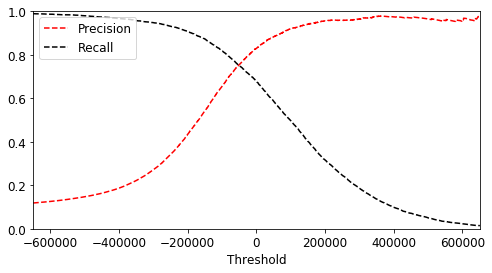

In [137]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "r--", label="Precision", linewidth=1.5)
    plt.plot(thresholds, recalls[:-1], "k--", label="Recall", linewidth=1.5)
    plt.xlabel("Threshold", fontsize=12)
    plt.legend(loc="upper left", fontsize=12)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-650000, 650000])
plt.show()

# Multiclass classification

### OvA or OvO?

In [175]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

Here, `scikit-learn` has automatically run one-vs-all classifier, and has picked the highest scored class, 5. This can be explicitly seen below.

In [179]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(str(some_digit_scores)+" which clearly has max at "+str(np.argmax(some_digit_scores)))

[[ -71753.31438351 -493368.97053619 -314056.76040747 -100018.39251247
  -397976.63201336    7337.01739509 -721868.88485811 -219254.09694955
  -697391.69829434 -827329.43754035]] which clearly has max at 5


Note that the classes are arranged as

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

If we wish, we can force `scikit-learn` to instead use OvO, which makes 45 comparisons, instead of 9!

In [182]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
print(str(ovo_clf.predict([some_digit]))+"; we made "+str(len(ovo_clf.estimators_))+" comparisons")

[5.]; we made 45 comparisons


### Random Forest Classifier

In [188]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=40)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [189]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0.1, 0. , 0. ]])

In [190]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87957409, 0.87019351, 0.8680302 ])

In [191]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91061788, 0.90654533, 0.91053658])

This actually is pretty good performance, since a random classifier would be 10% accurate!

## Error Analysis

One way to analysis errors is to again compute the `confusion_matrix`

In [192]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5723,    2,   22,    9,   11,   57,   49,    8,   38,    4],
       [   1, 6465,   47,   24,    7,   38,   10,   12,  127,   11],
       [  49,   35, 5318,  108,   75,   28,  102,   62,  166,   15],
       [  42,   41,  136, 5341,    2,  237,   36,   55,  145,   96],
       [  18,   29,   31,   11, 5376,   11,   61,   30,   83,  192],
       [  69,   38,   37,  185,   71, 4609,  114,   28,  180,   90],
       [  24,   24,   43,    2,   40,   96, 5631,    6,   51,    1],
       [  28,   20,   71,   29,   62,   11,    7, 5776,   15,  246],
       [  52,  146,   72,  156,   15,  147,   62,   28, 5031,  142],
       [  41,   36,   26,   87,  163,   41,    2,  197,   78, 5278]])

Another way, of course, is good old, seeing!

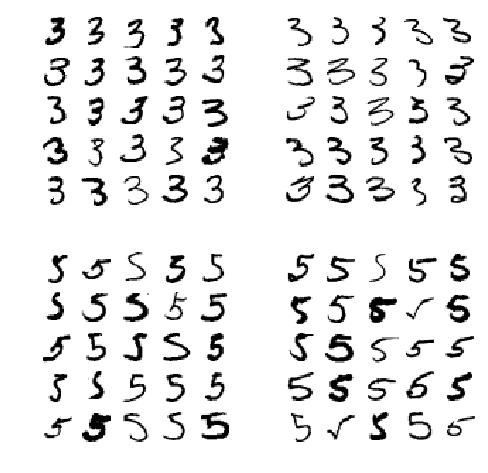

In [195]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()